<a href="https://colab.research.google.com/github/KenzaB27/segmentation-of-pelvic-bone/blob/main/src/vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup

In [1]:
!nvidia-smi

Sat May 29 09:19:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/KenzaB27/segmentation-of-pelvic-bone.git
!pip install SimpleITK
%cd /content/segmentation-of-pelvic-bone/src

Cloning into 'segmentation-of-pelvic-bone'...
remote: Enumerating objects: 318, done.
remote: Counting objects: 100% (318/318), done.
remote: Compressing objects: 100% (222/222), done.
remote: Total 318 (delta 187), reused 179 (delta 88), pack-reused 0
Receiving objects: 100% (318/318), 6.36 MiB | 21.02 MiB/s, done.
Resolving deltas: 100% (187/187), done.
     |████████████████████████████████| 47.4MB 107kB/s 
/content/segmentation-of-pelvic-bone/src


In [ ]:
!git pull

Already up to date.


In [4]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import SimpleITK as sitk
import analysis as ana
import numpy as np 
import importlib

import tensorflow as tf 
tfk = tf.keras
tfkl = tfk.layers

In [5]:
PATH = "/content/drive/My Drive/KTH/HL2027/"
DATA_PATH = PATH +'data/'

## Load Data

In [6]:
%%time
importlib.reload(ana)
data = ana.PelvicData(root_path=PATH)

CPU times: user 7.32 s, sys: 1.36 s, total: 8.68 s
Wall time: 20 s


In [ ]:
print(f"X train shape:{data.X_train_3C.shape}, y train shape:{data.y_train.shape} ")
print(f"X val shape:{data.X_val_3C.shape}, y val shape:{data.y_val.shape} ")

X train shape:(815, 300, 150, 3), y train shape:(815,) 
X val shape:(43, 300, 150, 3), y val shape:(43,) 


In [ ]:
print('Min: %.3f, Max: %.3f' % (data.cmn_img[42].min(), data.cmn_img[42].max()))

Min: -1024.000, Max: 3071.000


In [ ]:
print('Min: %.3f, Max: %.3f' % (data.X_val_3C.min(), data.X_val_3C.max()))

Min: -2.628, Max: 1.531


In [ ]:
print('Min: %.3f, Max: %.3f' % (data.X_flat_val.min(), data.X_flat_val.max()))

Min: -2.628, Max: 1.531


In [ ]:
X = data.X_flat_train.reshape(data.X_train.shape)
print('Min: %.3f, Max: %.3f' % (X.min(), X.max()))
X_3c = np.array(
            [np.repeat(x[None, ...], 3, axis=0).T for x in X])
print('Min: %.3f, Max: %.3f' % (X_3c.min(), X_3c.max()))

Min: 0.000, Max: 1.000
Min: 0.000, Max: 1.000


In [76]:
X_train, y_train, X_val, y_val = data.X_train_3C, data.y_train, data.X_val_3C, data.y_val
X_train = tf.image.per_image_standardization(X_train)
X_val = tf.image.per_image_standardization(X_val)

## VGG 16

In [77]:
input = tfkl.Input([None, None, 3])
x = tf.cast(input, tf.float32)
x = tf.image.per_image_standardization(x)
vgg_model = tfk.applications.VGG16(weights="imagenet", include_top=False, pooling="max")
vgg_output = vgg_model(x)
hidden_layer = tfkl.Dense(128, activation='relu')(vgg_output)
# hl_reg = tfkl.Dropout(0.7)(hidden_layer)
# hidden_layer = tfkl.Dense(256, activation='relu')(hl_reg)
# hl_reg = tfkl.Dropout(0.7)(hidden_layer)
# hidden_layer = tfkl.Dense(32, activation='relu')(hidden_layer)
# hl_reg = tfkl.Dropout(0.5)(hidden_layer)
# hidden_layer = tfkl.Dense(128, activation='relu')(hl_reg)
# hl_reg = tfkl.Dropout(0.5)(hidden_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hidden_layer)
model = tf.keras.models.Model(inputs=input, outputs=output_layer)

In [47]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
tf.cast_5 (TFOpLambda)       (None, None, None, 3)     0         
_________________________________________________________________
tf.image.per_image_standardi (None, None, None, 3)     0         
_________________________________________________________________
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 14,977,857
Trainable params: 263,169
Non-trainable params: 14,714,688
_________________________________________

### Training 

In [78]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-3)
model.compile(optimizer="adam", loss='binary_crossentropy', 
              metrics=['acc'])

In [79]:
!rm -r /content/drive/MyDrive/KTH/HL2027/checkpoint/vgg/*
!ls  /content/drive/MyDrive/KTH/HL2027/checkpoint/vgg

In [80]:
checkpoint_filepath = PATH + '/checkpoint/vgg/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)
history = model.fit(x=X_train, y=y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])
model.load_weights(checkpoint_filepath)

Epoch 1/25
26/26 [==============================] - 4s 130ms/step - loss: 0.4009 - acc: 0.8650 - val_loss: 0.2308 - val_acc: 0.9535
Epoch 2/25
26/26 [==============================] - 3s 122ms/step - loss: 0.1775 - acc: 0.9301 - val_loss: 0.1059 - val_acc: 0.9302
Epoch 3/25
26/26 [==============================] - 3s 121ms/step - loss: 0.1129 - acc: 0.9497 - val_loss: 0.0743 - val_acc: 1.0000
Epoch 4/25
26/26 [==============================] - 3s 122ms/step - loss: 0.0808 - acc: 0.9767 - val_loss: 0.0569 - val_acc: 1.0000
Epoch 5/25
26/26 [==============================] - 3s 122ms/step - loss: 0.0674 - acc: 0.9791 - val_loss: 0.0485 - val_acc: 1.0000
Epoch 6/25
26/26 [==============================] - 3s 121ms/step - loss: 0.0542 - acc: 0.9926 - val_loss: 0.0457 - val_acc: 1.0000
Epoch 7/25
26/26 [==============================] - 3s 122ms/step - loss: 0.0404 - acc: 0.9902 - val_loss: 0.0269 - val_acc: 1.0000
Epoch 8/25
26/26 [==============================] - 3s 121ms/step - loss: 0.

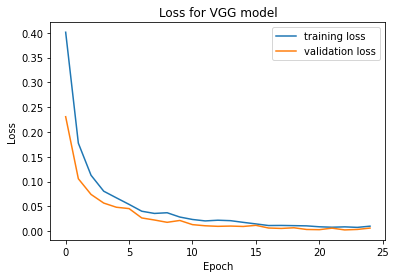

In [81]:
plt.figure()
plt.plot(history.history["loss"], label="training loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.title("Loss for VGG model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# plt.savefig(f'{PATH}/images/vgg_loss128.png')
plt.show()

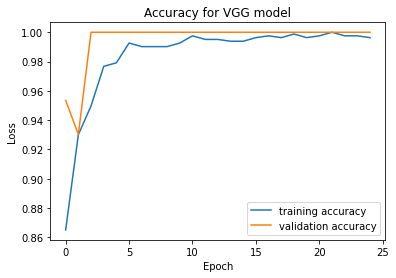

In [82]:
plt.figure()
plt.plot(history.history["acc"], label="training accuracy")
plt.plot(history.history["val_acc"], label="validation accuracy")
plt.title("Accuracy for VGG model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# plt.savefig(f'{PATH}/images/vgg_ac128.png')

plt.show()

# Test Performance on Common Images

In [ ]:
cmn_img.shape

(286, 512, 512, 3)

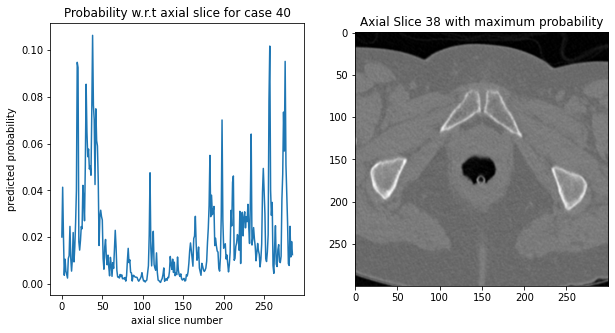

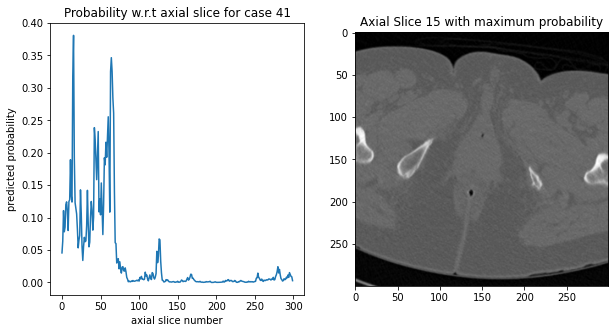

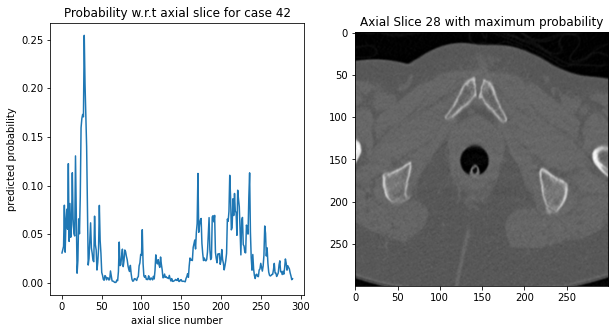

CPU times: user 4.79 s, sys: 164 ms, total: 4.96 s
Wall time: 4.53 s


In [83]:
%%time
for id, cmn_img in data.cmn_img_3c.items():
  # X_flat = np.array([x.flatten() for x in cmn_img])
  # X_flat = data.scaler.transform(X_flat)
  # X = X_flat.reshape(cmn_img.shape)
  # X = np.array(
  #           [np.repeat(x[None, ...], 3, axis=0).T for x in X])
  X_test = tf.image.per_image_standardization(cmn_img)
  y_pred = model.predict(X_test)
  argmax = np.argmax(y_pred)
  plt.figure(figsize=(10,5))

  plt.subplot(121)
  plt.plot(y_pred)
  plt.xlabel("axial slice number")
  plt.ylabel("predicted probability")
  plt.title(f"Probability w.r.t axial slice for case {id}")

  plt.subplot(122)
  plt.imshow(data.cmn_img[id][argmax], cmap="gray")
  plt.title(f"Axial Slice {argmax} with maximum probability")
  # plt.savefig(f'{PATH}/images/vgg_{id}.png')
  plt.show()

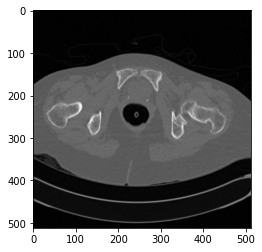

In [ ]:
plt.imshow(data.cmn_img[42][48], cmap="gray")

In [ ]:
print(data.cmn_img[40].min(), data.cmn_img[40].max())
print(data.cmn_img[41].min(), data.cmn_img[41].max())
print(data.cmn_img[42].min(), data.cmn_img[42].max())

-1024 3071
-1024 3071
-1024 3071


In [ ]:
model.predict(data.cmn_img_3c[42][48].reshape(1,512,512,3))

array([[0.]], dtype=float32)

## SVM

In [ ]:
X_train, y_train, X_val, y_val = data.X_flat_train, data.y_train, data.X_flat_val, data.y_val

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
clf = svm.SVC(kernel='rbf', C=100, gamma = 0.01, probability=True, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)

In [ ]:
scores

array([0.88343558, 0.88343558, 0.88343558, 0.87730061, 0.87730061])

In [ ]:
clf.fit(X_train, y_train)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

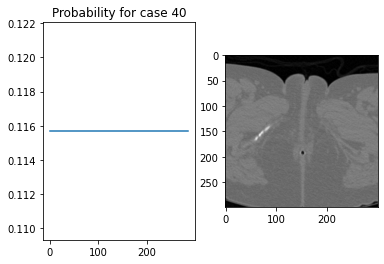

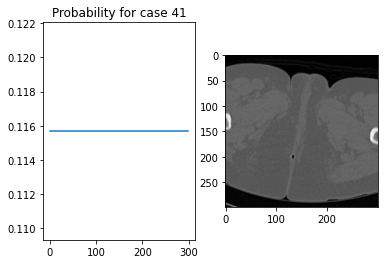

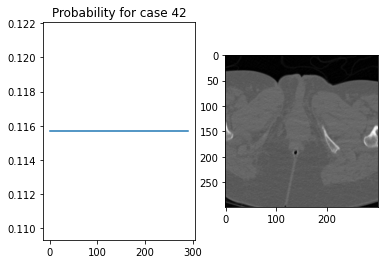

In [ ]:
for id, cmn_img in data.cmn_img.items():
  X_flat = np.array([x.flatten() for x in cmn_img])
  X_flat = data.scaler.transform(X_flat)
  y_pred = clf.predict_proba(X_flat)[:,1]
  argmax = np.argmax(y_pred)
  plt.figure()
  
  plt.subplot(121)
  plt.plot(y_pred)
  plt.title(f"Probability for case {id}")

  plt.subplot(122)
  plt.imshow(data.cmn_img[id][argmax], cmap="gray")
  plt.show()